## Tiger Census
* https://www2.census.gov/geo/pdfs/maps-data/data/tiger/tgrshp2019/TGRSHP2019_TechDoc.pdf
* S1200 - secondary road
* S1100 - primary road
* S1400 - local roads


In [1]:
import dask.dataframe as dd
import dask_geopandas as dg

import geopandas as gpd
import pandas as pd
from calitp_data_analysis.sql import to_snakecase
import datetime


from segment_speed_utils.project_vars import analysis_date
from segment_speed_utils import helpers
from shared_utils import  dask_utils, geography_utils, utils

GCS_FILE_PATH = "gs://calitp-analytics-data/data-analyses/"
SHARED_GCS = f"{GCS_FILE_PATH}shared_data/"

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/dask_geopandas/backends.py:13: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/l

In [2]:
pd.options.display.max_columns = 100
pd.options.display.float_format = "{:.2f}".format
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)

### GTFS Shapes

In [3]:
def gtfs_shapes_operators(date):
    """
    Load and merge gtfs_shapes 
    with trips to get operator and 
    feed key information.
    
    Returns a gpd.DataFrame.
    """
    gtfs_shapes = helpers.import_scheduled_shapes(date).compute()
    
    trips = helpers.import_scheduled_trips(date,(),['feed_key','name','shape_array_key']).compute().drop_duplicates()
    
    m1 = pd.merge(gtfs_shapes, trips, how="outer", on="shape_array_key")
    return m1

In [4]:
merge1 = gtfs_shapes_operators(analysis_date)

In [5]:
merge1.shape

(6488, 4)

In [6]:
type(merge1)

geopandas.geodataframe.GeoDataFrame

In [21]:
# merge1.plot()

* https://www.energy.ca.gov/data-reports/energy-almanac/transportation-energy/public-transit-california

In [70]:
def operators(date):
    df = helpers.import_scheduled_trips(analysis_date,(),['name']).compute().sort_values('name')
    df = df.name.unique().tolist()
    
    # Reorder list so the biggest operators are at the beginning
    # based on NTD services data 
    big_operators = ['LA DOT Schedule',
     'LA Metro Bus Schedule',
     'LA Metro Rail Schedule',
     'Bay Area 511 Muni Schedule',
     'Bay Area 511 AC Transit Schedule',
     'Bay Area 511 Santa Clara Transit Schedule',
     'Bay Area 511 BART Schedule',
     'San Diego Schedule','OCTA Schedule','Sacramento Schedule',
    ]
    
    for operator in big_operators:
        df.remove(operator)
        for index_number in range(len(big_operators)):
            df.insert(index_number, operator)
    return df

In [71]:
test_list = operators(analysis_date)

### Tiger

In [10]:
#roads = to_snakecase(gpd.read_parquet(
  #       f"{SHARED_GCS}all_roads_2020_state06.parquet")).to_crs(geography_utils.CA_NAD83Albers)

In [11]:
primary_secondary_mtfcc = ['S1100','S1200']

In [12]:
def load_roads(road_type_wanted:list):
    df = gpd.read_parquet(
         f"{SHARED_GCS}all_roads_2020_state06.parquet", 
         filters =[('MTFCC', 'in', road_type_wanted)],
         columns = ["LINEARID", "MTFCC", "geometry"]
    ).to_crs(geography_utils.CA_NAD83Albers)
    
    df = df.assign(
        geometry = df.geometry.buffer(200)
    )
    
    df = to_snakecase(df)
    
    return df

In [13]:
primary_secondary_roads = load_roads(primary_secondary_mtfcc)

In [14]:
primary_secondary_roads.mtfcc.value_counts()

S1200    6193
S1100    1252
Name: mtfcc, dtype: int64

In [15]:
primary_secondary_roads.shape

(7445, 3)

<AxesSubplot:>

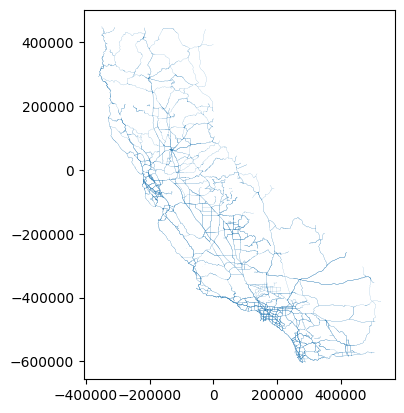

In [16]:
primary_secondary_roads.plot()

In [17]:
def join_primary_secondary():
    start = datetime.datetime.now()
    # Load Shapes
    shapes = gtfs_shapes_operators(analysis_date)
    
    # Load secondary-primary shapes
    primary_secondary_mtfcc = ['S1100','S1200']
    primary_secondary_roads = load_roads(primary_secondary_mtfcc)
    
    sjoin1 = gpd.sjoin(
        primary_secondary_roads,
        shapes,
        how = "inner",
        predicate = "intersects"
    ).drop_duplicates().reset_index(drop=True)
    
    end = datetime.datetime.now()
    print(f"time lapsed: {end-start}")
    
    return sjoin1

In [18]:
test = join_primary_secondary()

time lapsed: 0:00:32.320230


<AxesSubplot:>

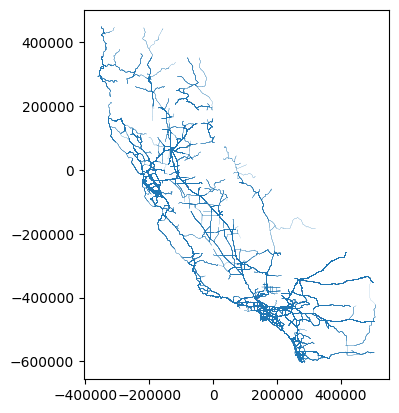

In [19]:
test.plot()